In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import golden
plt.style.use('default')

In [2]:
csvfile = '../csv/alldata.csv'
distance_param = 'CDistance'
tragitti = pd.read_csv(csvfile, index_col=False)

pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] < 13)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)

def clean(df):
    hour_cond = df['Hour'] != 0
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = hour_cond & distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [3]:
tragitti = tragitti[post_lock_cond]
tragitti = tragitti[clean(tragitti)]

replace = {}
replace['Car'] = 'Auto'
replace['Public'] = 'ATM'
replace['Bike'] = 'Bici'
replace['Foot'] = 'A piedi'
replace['Enjoy'] = 'Enjoy'

colori = ['slategray', 'firebrick', 'darkorange', 'limegreen', 'slateblue']
myindex = [
    '7:00', '8:00', '9:00', '10:00',
    '11:00', '12:00', '13:00', '14:00',
    '15:00','16:00', '17:00', '18:00',
    '19:00', '20:00', '21:00', '22:00',
    '23:00']
plterrindex = [
    '10:00', '11:00', '12:00', '13:00',
    '14:00', '15:00','16:00', '17:00',
    '18:00', '19:00', '20:00', '21:00',
    '22:00', '23:00', '7:00', '8:00',
    '9:00'] # pyplot stupido

def list_minus(l1, l2):
    r = []
    for i in range(0, len(l1)):
        r.append(l1[i] - l2[i])
    return r

def tmedio_carsharing_auto(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = tragitti_fascia_oraria[mezzo] - tragitti_fascia_oraria['Car']
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore

def vstd_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = tragitti_fascia_oraria[mezzo] - tragitti_fascia_oraria['Car']
        vmedia_giorno_ore.append(2 * np.std(velocita_media_oraria, ddof=1))
    return vmedia_giorno_ore

def week_filters(df):
    weeks = \
        ((df['Month'] == 5) & (
            (df['Day'].between(4, 8)) |
            (df['Day'].between(11, 15)) |
            (df['Day'].between(18, 22)) |
            (df['Day'].between(25, 29)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1, 5)) |
            (df['Day'].between(8, 12)) |
            (df['Day'].between(15, 19)) |
            (df['Day'].between(22, 26))))

    weekends = \
        ((df['Month'] == 5) & (
            (df['Day'].between(9, 10)) |
            (df['Day'].between(16, 17)) |
            (df['Day'].between(23, 24)) |
            (df['Day'].between(30, 31)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(6, 7)) |
            (df['Day'].between(13, 14)) |
            (df['Day'].between(20, 21)) |
            (df['Day'].between(27, 28))))
    
    return weeks, weekends

w, we = week_filters(tragitti)

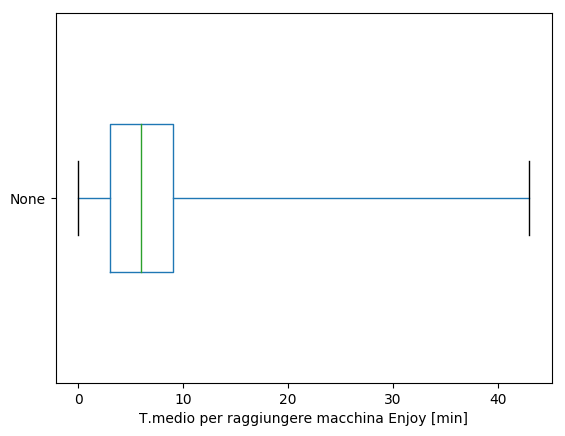

count    46902.000000
mean         6.580956
std          4.541093
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         43.000000
dtype: float64

In [4]:
sample = (tragitti['Enjoy'] - tragitti['Car'])
sample.plot.box(vert=False, whis='range', widths=.4)
plt.xlabel('T.medio per raggiungere macchina Enjoy [min]')
plt.show()

sample.describe()

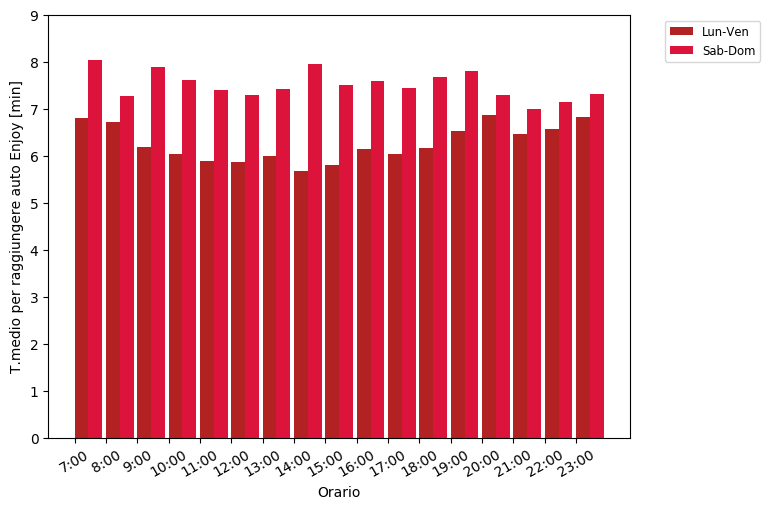

In [5]:
tw_means, tw_std = tmedio_carsharing_auto(tragitti[w], 'Enjoy'), np.round(vstd_giorno(tragitti[w], 'Enjoy'), 1).tolist()
twe_means, twe_std =  tmedio_carsharing_auto(tragitti[we], 'Enjoy'), np.round(vstd_giorno(tragitti[we], 'Enjoy'), 1).tolist()

ind = np.arange(len(tw_means))
width = 0.44  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tw_means, width, label='Lun-Ven', color='firebrick', align='edge')
rects2 = ax.bar(ind + width, twe_means, width, label='Sab-Dom',  color='crimson', align='edge')

fig.tight_layout()

ax.set_xticks(ind)
ax.set_xticklabels(myindex)

plt.xlabel('Orario')
plt.ylabel('T.medio per raggiungere auto Enjoy [min]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 10, 1))
plt.setp(ax.get_xticklabels(), rotation=30)

plt.show()

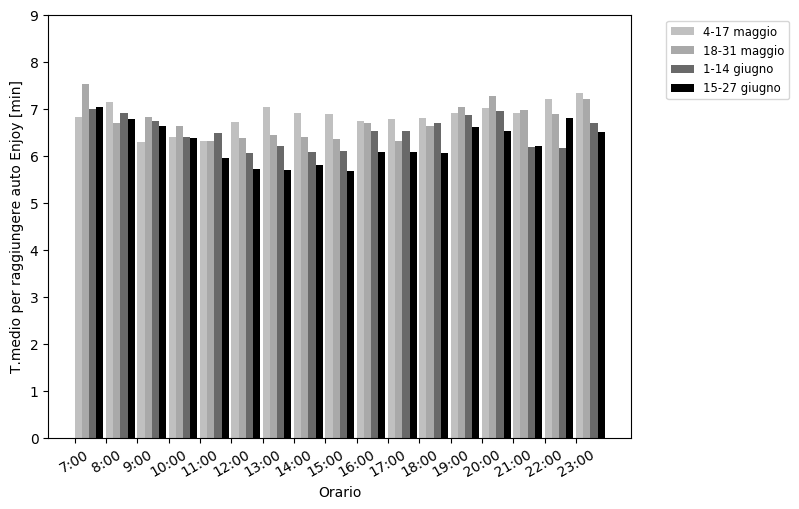

In [6]:
tw12 = tmedio_carsharing_auto(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Enjoy')
tw34 = tmedio_carsharing_auto(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Enjoy')
tw56 = tmedio_carsharing_auto(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Enjoy')
tw78 = tmedio_carsharing_auto(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Enjoy')

ind = np.arange(len(tw12))
width = 0.23  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tw12, width, label='4-17 maggio', color='silver', align='edge')
rects2 = ax.bar(ind + width, tw34, width, label='18-31 maggio',  color='darkgray', align='edge')
rects1 = ax.bar(ind + width * 2, tw56, width, label='1-14 giugno', color='dimgray', align='edge')
rects2 = ax.bar(ind + width * 3, tw78, width, label='15-27 giugno',  color='black', align='edge')

fig.tight_layout()

ax.set_xticks(ind)
ax.set_xticklabels(myindex)

plt.xlabel('Orario')
plt.ylabel('T.medio per raggiungere auto Enjoy [min]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 10, 1))
plt.setp(ax.get_xticklabels(), rotation=30)

plt.show()

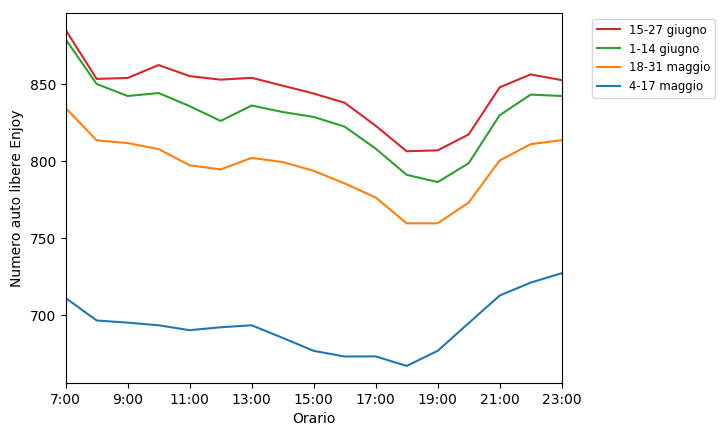

In [7]:
# Velocita' media durante il giorno
def macchine_libere_giorno(df):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        vmedia_giorno_ore.append(tragitti_fascia_oraria['EnjoyFreeCars'].mean())
    return vmedia_giorno_ore

lst = [
    macchine_libere_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)]),
    macchine_libere_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)]),
    macchine_libere_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)]),
    macchine_libere_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)])]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=myindex,
    columns=['4-17 maggio', '18-31 maggio', '1-14 giugno', '15-27 giugno']).round(decimals=1)

confronto_vmedie_week_by_week.plot()
plt.yticks(range(700, 900, 50))
plt.xlabel('Orario')
plt.ylabel('Numero auto libere Enjoy')
plt.legend(reversed(plt.legend().legendHandles), reversed(['4-17 maggio', '18-31 maggio', '1-14 giugno', '15-27 giugno']), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

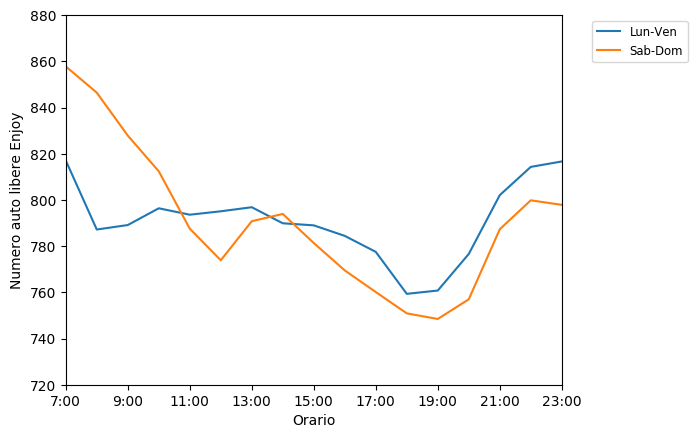

In [8]:
lst = [
    macchine_libere_giorno(tragitti[w]),
    macchine_libere_giorno(tragitti[we])]
array = np.array(lst).T

pd.DataFrame(array, index=myindex, columns=['Lun-Ven', 'Sab-Dom']).round(2).plot()
plt.yticks(range(720, 881, 20))
plt.xlabel('Orario')
plt.ylabel('Numero auto libere Enjoy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

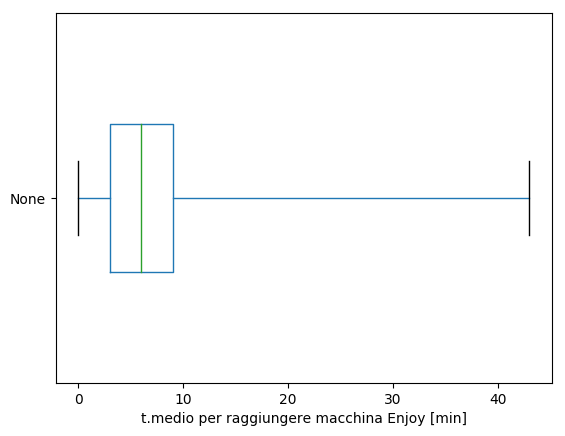

count    30829.000000
mean         6.543579
std          4.579328
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         43.000000
dtype: float64

In [9]:
tragitti = tragitti[((tragitti['Month'] == 5) & (tragitti['Day'] > 17)) | (tragitti['Month'] == 6)]

sample = (tragitti['Enjoy'] - tragitti['Car'])
sample.plot.box(vert=False, whis='range', widths=.4)
plt.xlabel('t.medio per raggiungere macchina Enjoy [min]')
plt.show()

sample.describe()